# Wildfire Prediction in Satellite Imagery



![img](images/WildfireCanada.png)


Credits: [CBC](https://www.cbc.ca/radio/ideas/world-on-fire-canada-s-worst-wildfire-season-on-record-1.6946472) + [Logos-World](https://logos-world.net/government-of-canada-logo/)

## Objectives

To use the Canada Wildfire dataset and build a model that can predict whether an area is at risk of a wildfire or not.

## Dataset

### Source

Refer to Canada's website for the original wildfires data:
Forest Fires - Open Government Portal

Original license for the data:
Creative Commons 4.0 Attribution (CC-BY) license – Quebec

### About Dataset

This dataset contains satellite images (350x350px) in 2 classes :

- Wildfire : 22710 images
- No wildfire : 20140 images

The data was divided into train, test and validation with these percentages :

- Train : ~70%
- Test : ~15%
- Validation : ~15%

### How was the dataset created

Using Longitude and Latitude coordinates for each wildfire spot (> 0.01 acres burned) found on the dataset above we extracted satellite images of those areas using MapBox API to create a more convenient format of the dataset for deep learning and building a model that can predict whether an area is at risk of a wildfire or not

- Dataset on Kaggle: [Wildfire Prediction Dataset (Satellite Images)](https://www.kaggle.com/datasets/abdelghaniaaba/wildfire-prediction-dataset/data) 

In [4]:
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image
import random

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [5]:
# Define the directories
train_dir = '/Users/pramodkondur/Downloads/wildfirearchive/train' # Replace with your train directory
valid_dir = '/Users/pramodkondur/Downloads/wildfirearchive/valid' # Replace with your validation directory
test_dir = '/Users/pramodkondur/Downloads/wildfirearchive/test'   # Replace with your test directory

In [6]:
# Function to display one random sample from each class
def display_random_sample(dataset_dir):
    classes = os.listdir(dataset_dir)  # List of class directories
    plt.figure(figsize=(15, 10))  # Adjust the figure size if needed

    for i, class_name in enumerate(classes):
        class_dir = os.path.join(dataset_dir, class_name)
        image_files = os.listdir(class_dir)  # Get all images in the class folder
        random_image = random.choice(image_files)  # Select a random image
        img_path = os.path.join(class_dir, random_image)
        
        # Load the image with its original size
        img = load_img(img_path)
        
        # Display the image
        plt.subplot(1, len(classes), i + 1)  # Display images in a single row
        plt.imshow(img)
        plt.axis('off')  # Turn off axis for better visualization
        plt.title(f"{class_name} ({img.size[0]}x{img.size[1]})")  # Show class name and image size

    plt.show()


Training set samples:


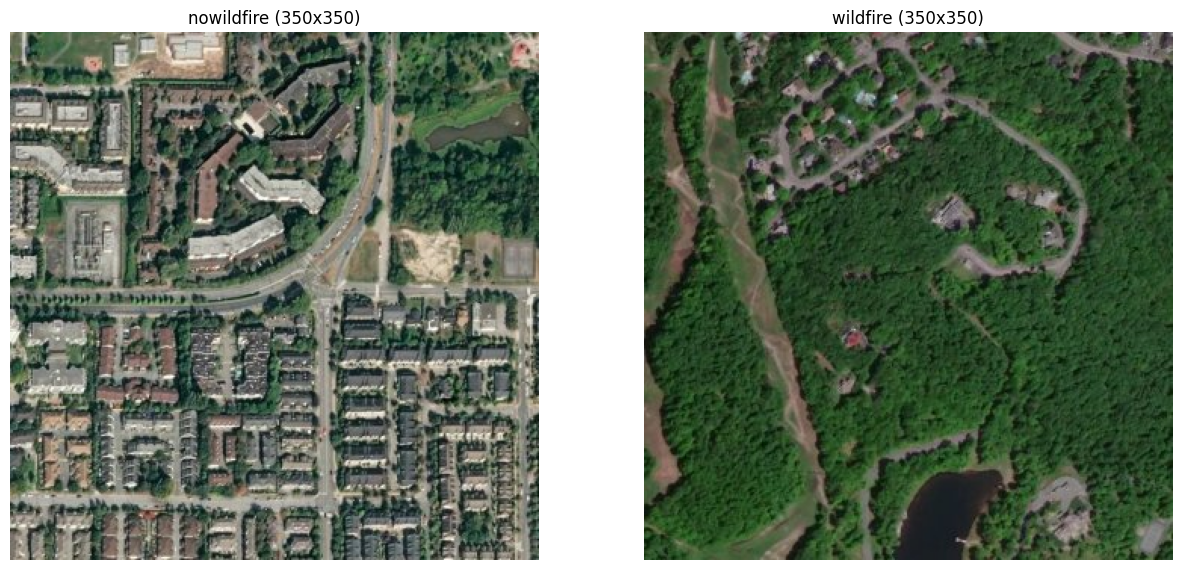

Validation set samples:


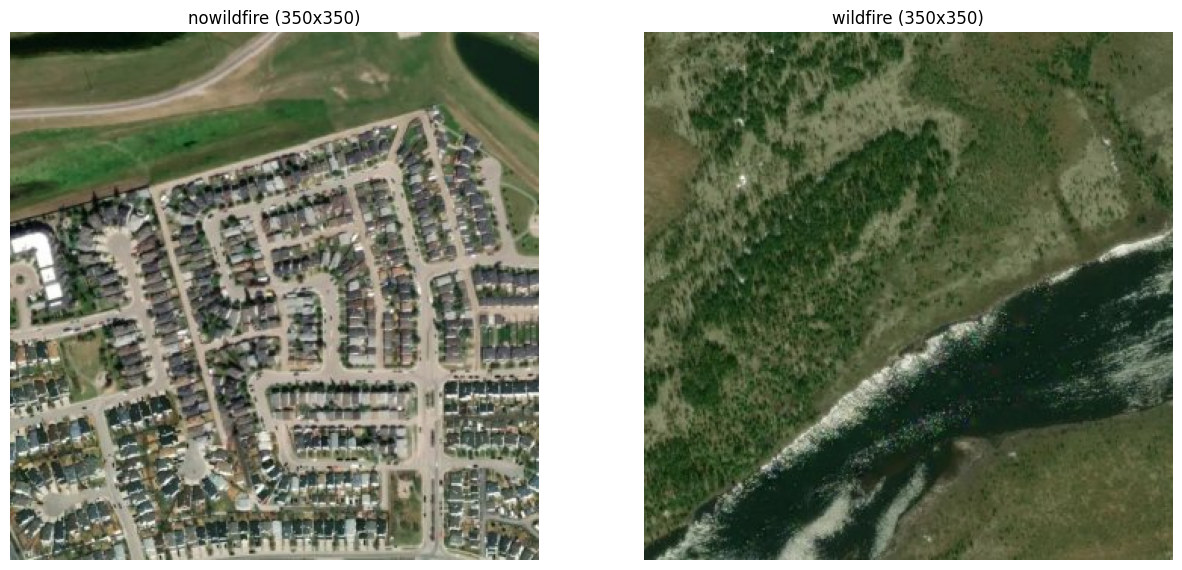

Test set samples:


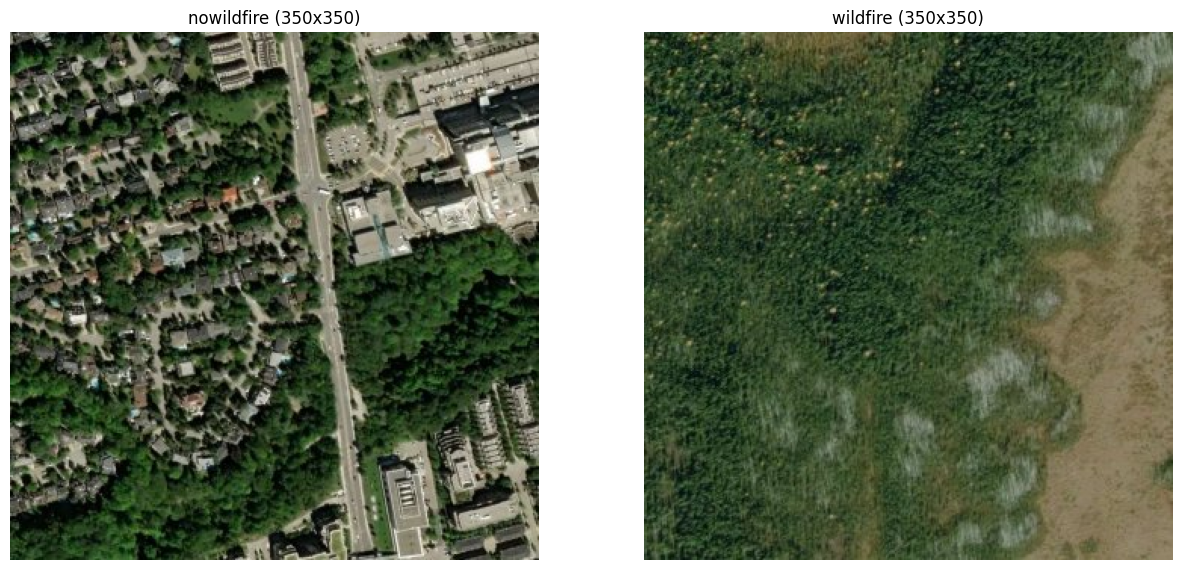

In [7]:
# Display one random sample from train, validation, and test sets
print("Training set samples:")
display_random_sample(train_dir)

print("Validation set samples:")
display_random_sample(valid_dir)

print("Test set samples:")
display_random_sample(test_dir)

In [8]:
dir = '/Users/pramodkondur/Downloads/wildfirearchive/train'
x_train = []
y_train = []
for direct in os.listdir(dir):
    print("Loading dataset training {}".format(direct))
    for filename in os.listdir(os.path.join(dir,direct)):
        img_path = os.path.join(dir,direct,filename)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (32,32))
        img = np.array(img)
        img = img/255
        x_train.append(img)
        y_train.append(direct)

Loading dataset training nowildfire


Premature end of JPEG file


Loading dataset training wildfire


In [9]:
dir_val = '/Users/pramodkondur/Downloads/wildfirearchive/valid'
x_val=[]
y_val=[]
for direct in os.listdir(dir_val):
    print("Loading dataset validation {}".format(direct))
    for filename in os.listdir(os.path.join(dir_val,direct)):
        img_path = os.path.join(dir_val,direct,filename)
        image = cv2.imread(img_path)
        image = cv2.resize(image,(32,32))
        image = np.array(image)
        image = image/255
        x_val.append(image)
        y_val.append(direct)

Loading dataset validation nowildfire
Loading dataset validation wildfire


In [10]:
dir_test = '/Users/pramodkondur/Downloads/wildfirearchive/test'
x_test=[]
y_test=[]
for direct in os.listdir(dir_test):
    print("Loading dataset test {}".format(direct))
    for filename in os.listdir(os.path.join(dir_test,direct)):
        img_path = os.path.join(dir_test,direct,filename)
        image = cv2.imread(img_path)
        image = cv2.resize(image,(32,32))
        image = np.array(image)
        image = image/255
        x_test.append(image)
        y_test.append(direct)

Loading dataset test nowildfire
Loading dataset test wildfire


Premature end of JPEG file


In [11]:
x_train = np.array(x_train)
x_val = np.array(x_val)
x_test = np.array(x_test)

In [15]:
y_train[30000]

'wildfire'

In [16]:
# Replace "wildfire" with 1 and "nowildfire" with 0
y_train = [1 if label == 'wildfire' else 0 for label in y_train]
y_val = [1 if label == 'wildfire' else 0 for label in y_val]
y_test = [1 if label == 'wildfire' else 0 for label in y_test]

In [17]:
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [28]:
len(x_train[3][3])

32

In [29]:
# Now check the shape of your datasets
print("x_train shape:", x_train.shape)  # Should be (num_samples, height, width, num_channels)
print("x_valid shape:", x_val.shape)
print("x_test shape:", x_test.shape)

print("y_train shape:", y_train.shape)
print("y_valid shape:", y_val.shape)
print("y_test shape:", y_test.shape)

x_train shape: (30250, 32, 32, 3)
x_valid shape: (6300, 32, 32, 3)
x_test shape: (6300, 32, 32, 3)
y_train shape: (30250,)
y_valid shape: (6300,)
y_test shape: (6300,)


In [30]:
# Step 1: Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    
    Flatten(),
    
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    BatchNormalization(),
    
    Dense(1, activation='sigmoid')  # Output layer with number of classes
])

# Step 2: Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # Loss function for two-class classification
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 30, 30, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 30, 30, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 30, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 15, 15, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 3, 3, 128)      │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 3, 3, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32)             │           12

 Total params: 1,782,529 (6.80 MB)

 Trainable params: 1,781,313 (6.80 MB)

 Non-trainable params: 1,216 (4.75 KB)

In [31]:
from tensorflow.keras.callbacks import EarlyStopping

# Step 3: Train the model
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=20,
    batch_size=64,
    callbacks=[EarlyStopping(monitor='val_loss', patience=4)]
)


Epoch 1/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 148s 309ms/step - accuracy: 0.8842 - loss: 0.2893 - val_accuracy: 0.8730 - val_loss: 0.3089
Epoch 2/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 166s 351ms/step - accuracy: 0.9257 - loss: 0.1849 - val_accuracy: 0.9219 - val_loss: 0.2106
Epoch 3/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 178s 376ms/step - accuracy: 0.9325 - loss: 0.1705 - val_accuracy: 0.8029 - val_loss: 0.4212
Epoch 4/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 213s 451ms/step - accuracy: 0.9388 - loss: 0.1559 - val_accuracy: 0.9479 - val_loss: 0.1606
Epoch 5/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 225s 475ms/step - accuracy: 0.9467 - loss: 0.1419 - val_accuracy: 0.9475 - val_loss: 0.1484
Epoch 6/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 244s 516ms/step - accuracy: 0.9500 - loss: 0.1328 - val_accuracy: 0.8778 - val_loss: 0.3563
Epoch 7/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 220s 465ms/step - accuracy: 0.9505 - loss: 0.1317 - val_accuracy: 0.9200 - val_loss: 0.2194
Epoch 8/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 202s 428ms/step - accuracy: 0.9550 -

In [32]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(x_test, y_test)

print(f'Test Accuracy: {test_accuracy:.4f}')

197/197 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9657 - loss: 0.0913
Test Accuracy: 0.9467


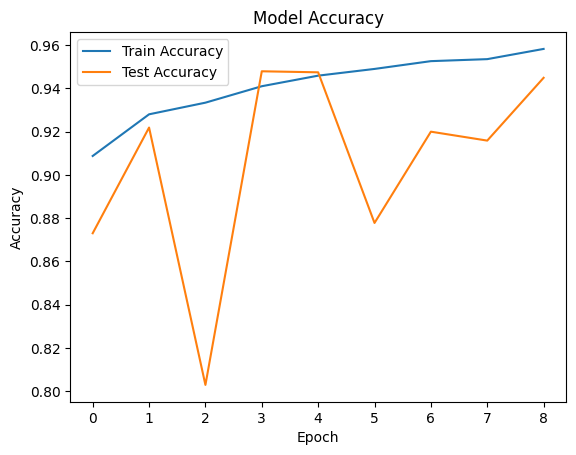

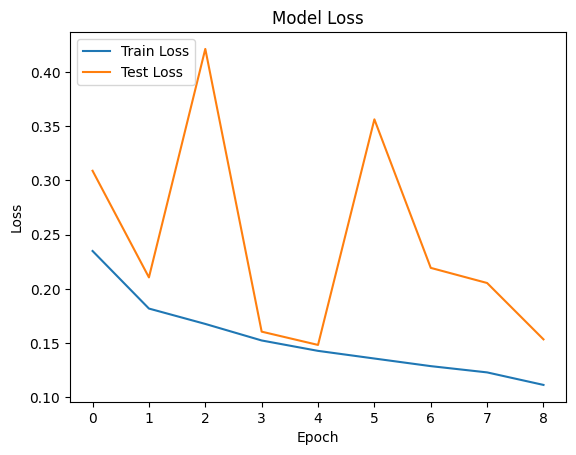

In [33]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

In [34]:
# Predict on the datasets
y_train_pred = model.predict(x_train)
y_val_pred = model.predict(x_val)
y_test_pred = model.predict(x_test)

# Convert probabilities to binary classes if using a classification model
y_train_pred_classes = (y_train_pred > 0.5).astype("int32")
y_val_pred_classes = (y_val_pred > 0.5).astype("int32")
y_test_pred_classes = (y_test_pred > 0.5).astype("int32")

946/946 ━━━━━━━━━━━━━━━━━━━━ 38s 40ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step


Confusion matrix for train: 



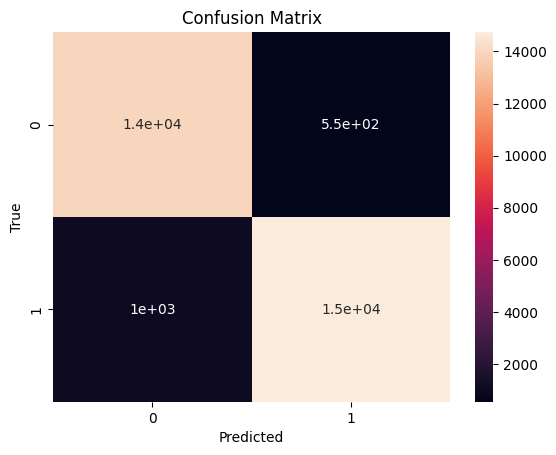

In [35]:
print("Confusion matrix for train: \n")
cm = confusion_matrix(y_train, y_train_pred_classes)
sns.heatmap(cm, annot=True)
plt.title(f"Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [36]:
from sklearn.metrics import  classification_report

print(f"classification report for train : \n{classification_report(y_train, y_train_pred_classes)}")

classification report for train : 
              precision    recall  f1-score   support

           0       0.93      0.96      0.95     14500
           1       0.96      0.94      0.95     15750

    accuracy                           0.95     30250
   macro avg       0.95      0.95      0.95     30250
weighted avg       0.95      0.95      0.95     30250



Confusion matrix for valid: 



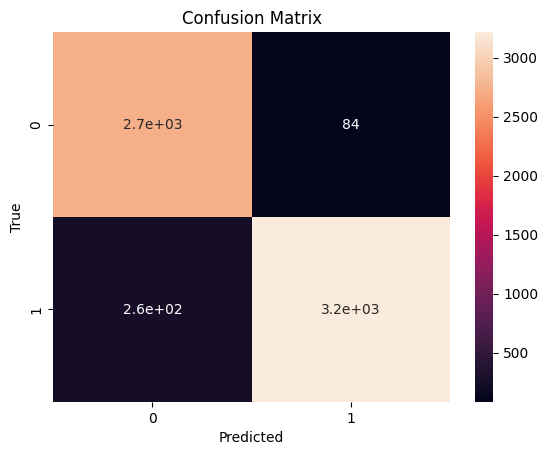

In [37]:
print("Confusion matrix for valid: \n")
cm = confusion_matrix(y_val, y_val_pred_classes)
sns.heatmap(cm, annot=True)
plt.title(f"Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [38]:
print(f"classification report for valid : \n{classification_report(y_val, y_val_pred_classes)}")

classification report for valid : 
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      2820
           1       0.97      0.92      0.95      3480

    accuracy                           0.94      6300
   macro avg       0.94      0.95      0.94      6300
weighted avg       0.95      0.94      0.95      6300



Confusion matrix for test: 



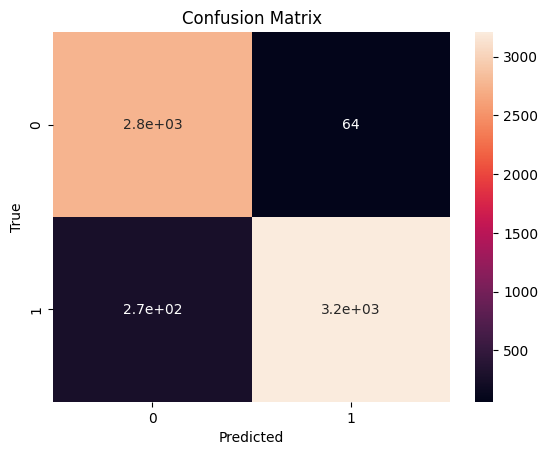

In [39]:
print("Confusion matrix for test: \n")
cm = confusion_matrix(y_test, y_test_pred_classes)
sns.heatmap(cm, annot=True)
plt.title(f"Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [40]:
print(f"classification report for test : \n{classification_report(y_test, y_test_pred_classes)}")

classification report for test : 
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      2820
           1       0.98      0.92      0.95      3480

    accuracy                           0.95      6300
   macro avg       0.95      0.95      0.95      6300
weighted avg       0.95      0.95      0.95      6300



---

# Results

The performance of the satellite imagery wildfire detection model was evaluated on a test dataset of 6,300 samples, comprising both wildfire and non-wildfire images. The model achieved an overall accuracy of **95%**, indicating strong classification ability in distinguishing between wildfire and non-wildfire events.

### Classification Report for Test Data

The following table summarizes the model's precision, recall, and F1-score for both classes (wildfire and non-wildfire):

| Class | Precision | Recall | F1-Score | Support |
|-------|-----------|--------|----------|---------|
| **0 (Non-wildfire)**  | 0.91      | 0.98   | 0.94     | 2820    |
| **1 (Wildfire)**      | 0.98      | 0.92   | 0.95     | 3480    |
| **Accuracy**          |           |        | 0.95     | 6300    |
| **Macro Avg**         | 0.95      | 0.95   | 0.95     | 6300    |
| **Weighted Avg**      | 0.95      | 0.95   | 0.95     | 6300    |

#### Interpretation:

- **Class 0 (Non-wildfire):**
    - **Precision:** 0.91 (91% of predicted non-wildfire images were correctly classified as non-wildfire).
    - **Recall:** 0.98 (98% of actual non-wildfire images were correctly identified).
    - **F1-Score:** 0.94 (Harmonic mean of precision and recall, balancing the two metrics).
    - **Support:** 2820 (Number of non-wildfire samples in the test set).

- **Class 1 (Wildfire):**
    - **Precision:** 0.98 (98% of predicted wildfire images were correctly classified as wildfire).
    - **Recall:** 0.92 (92% of actual wildfire images were successfully detected).
    - **F1-Score:** 0.95 (Strong balance between precision and recall for wildfire detection).
    - **Support:** 3480 (Number of wildfire samples in the test set).

- **Overall Performance:**
    - **Accuracy:** 0.95 (The model has a high overall accuracy in classifying both wildfire and non-wildfire images).
    - **Macro Average:**  
        - **Precision:** 0.95  
        - **Recall:** 0.95  
        - **F1-Score:** 0.95
    - **Weighted Average:**  
        - **Precision:** 0.95  
        - **Recall:** 0.95  
        - **F1-Score:** 0.95

In summary, the model demonstrates **strong performance** in both wildfire and non-wildfire classification, with high precision, recall, and balanced F1-scores for both classes. The overall accuracy of **95%** shows that the model is highly effective in distinguishing between wildfire and non-wildfire events.

---

# Next Steps

### 1. **Model Deployment:**
   - Deploy the trained model to a cloud or edge platform for real-time inference or batch processing.
   - Create an API for easy integration with satellite image data sources or monitoring systems.

### 2. **Integration with Satellite Data:**
   - Integrate the model with satellite data processing pipelines (e.g., from Landsat, Sentinel).
   - Preprocess incoming satellite images (e.g., resizing, normalization) before passing them to the model.

### 3. **Real-time Monitoring and Alerts:**
   - Develop an alert system to notify relevant stakeholders (e.g., emergency responders, forest rangers) in real-time when wildfires are detected.
   - Integrate model predictions with GIS systems to visualize wildfire locations and risk zones.

### 4. **Model Improvements:**
   - Retrain the model periodically with new satellite data to ensure that it remains accurate over time.
   - Implement active learning to allow the model to improve based on uncertain predictions and human feedback.

### 5. **Field Testing:**
   - Deploy the model in a specific region for testing, collecting feedback from real-world users (e.g., forest rangers) to fine-tune model performance and reduce false positives/negatives.

### 6. **Scaling the Model:**
   - Consider scaling the model for global wildfire detection by incorporating more satellite sources and training data.
   - Explore potential applications for other environmental monitoring tasks, such as deforestation detection.
